<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the Data</a></span><ul class="toc-item"><li><span><a href="#Define-and-create-a-Data-Loader" data-toc-modified-id="Define-and-create-a-Data-Loader-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define and create a Data Loader</a></span></li><li><span><a href="#Visualize-some-images" data-toc-modified-id="Visualize-some-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Visualize some images</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span></li><li><span><a href="#Network-Architecture" data-toc-modified-id="Network-Architecture-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network Architecture</a></span><ul class="toc-item"><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Generator</a></span></li></ul></li></ul></div>

# Libraries

In [23]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import problem_unittests as tests

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

# Load the Data

Already pre-processed!
The data has been cropped to just faces and resized to be 64x64x3 Numpy Images.
<img src='processed_face_data.png' width=100% />

> Download the data [here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

## Define and create a Data Loader

In [16]:
def get_dataloader(batch_size, image_size, data_dir='./data/processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # resize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                       transforms.ToTensor()])
    
    # define the datasets using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)
    
    # create and return DataLoaders
    dL = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dL

In [18]:
batch_size = 20
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

## Visualize some images

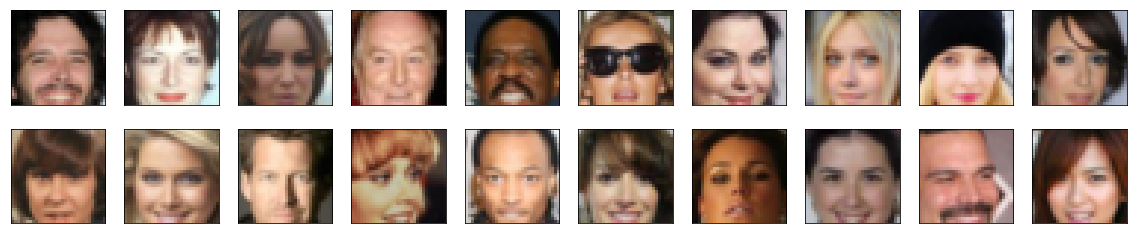

In [19]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

# Pre-processing

The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1. 
Rescale the training images to a range of -1 to 1. 

In [20]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values defined by feature_range. 
       '''
    
    # scale to feature_range and return scaled x
    oldMin, oldMax = x.min(), x.max()
    newMin, newMax = feature_range
    
    x = ((x - oldMin) / (oldMax - oldMin)) * (newMax - newMin) + newMin
    
    return x

In [22]:
# Test

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels
img = images[0]

# original
print('Original min: ', img.min())
print('Original max: ', img.max())

# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Original min:  tensor(0.)
Original max:  tensor(0.9137)
Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


# Network Architecture

## Discriminator
Use a convolutional classifier, but don't use any maxpooling layers.

** Inputs: **
    `32x32x3` tensor imagees
    
** Outputs: **
    single value probability image is real or fake

In [29]:
# helper convolutional layer function 
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    '''
    Creates a convolutional layer w/optional batch normalization
    '''
    
    # 2D convolutional layer
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    # appned the conv layer
    layers = []
    layers.append(conv_layer)
    
    if batch_norm:
        # append a batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # use sequential container to output the layers
    return nn.Sequential(*layers)

In [30]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # class variables
        self.conv_dim = conv_dim
        
        # Convolutional Layers
        #conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
       
        # 32 x 32 input - no batch norm on the first layer
        self.conv1 = conv(3, self.conv_dim, 4, 2, 1, False)
        
        # 16 x 16 input
        self.conv2 = conv(conv_dim, 2*conv_dim, 4, 2, 1, True)
        
        # 8 x 8 input
        self.conv3 = conv(2*conv_dim, 4*conv_dim, 4, 2, 1, True)
        
        # Fully Connected Layer
        # flattened 4x4 input from last conv. layer
        # outputs a class probability for real or fake
        self.fc = nn.Linear((4*conv_dim)*(4*4), 1)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        x: The input to the neural network     
        return: Discriminator logits; the output of the neural network
        """
        # feedforward behavior
        
        # convolutional layers w/Leaky ReLU activition
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        
        # flatten before passing to the linear layer
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        
        return x


## Generator
Use a series of transpose convolutional layers to upsample an random input vector.

** Inputs: **
Vectors of some length, `z_size`

** Outputs: **
3D array of shape `32x32x3`

In [31]:
# helper deconvolutional layer function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a transpose convolutional layer, w/optional batch normalization.
    """
    
     # 2D transpose convolutional layer
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    # appned the deconv layer
    layers = []
    layers.append(deconv_layer)
    
    if batch_norm:
        # append a batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # use sequential container to output the layers
    return nn.Sequential(*layers)
    